In [410]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, RidgeCV, LarsCV, Ridge, Lasso, LassoCV
from regressors import stats    
from sklearn.feature_selection import chi2

In [411]:
#Set some pandas parameters for outputs
pd.set_option('display.max_columns', 5)
pd.set_option('display.width', 1000)

In [412]:
### Define function for US map plotting ###
def plotByState(dataset, valueColName, stateColName = "State", countyColName = "FIPS Code", saveFilePath = "data/education/educationLevelsState.html"):
    #Extract only state data
    dataset = dataset[[countyColName, stateColName, valueColName]]
    datasetStates = dataset[dataset[countyColName]%1000 == 0]

    valueRange = (min(datasetStates[valueColName]), max(datasetStates[valueColName]))

    fig = px.choropleth(datasetStates, locations=datasetStates[stateColName], locationmode="USA-states",
    color=valueColName,color_continuous_scale="Viridis",
    range_color=valueRange,scope="usa",labels={valueColName:"Value"},
    hover_name=stateColName)
    
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.write_html(saveFilePath, auto_open=True)

def plotByCounty(dataset, valueColName, countyColName = "FIPS Code"):
    #Extract only state data
    dataset = dataset[dataset[countyColName]%1000 != 0]

    fig = px.choropleth(dataset, geojson=counties, locations=countyColName, 
    color=valueColName,color_continuous_scale="Viridis", range_color=(0, 50),scope="usa",
    labels={valueColName:"Value"},hover_name=countyColName)
    
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.write_html('data/education/educationLevelsCounty.html', auto_open=True)

In [5]:
#Load in cleaned dataset
educationDataset = pd.read_csv("data/cleaned/educationDataset.csv")

In [28]:
#Education Data
plotByState(educationDataset, "Percent of adults with a bachelor's degree or higher, 2014-18", saveFilePath = 'data/education/educationLevelsState.html')

In [29]:
#Economic Data
plotByState(educationDataset, "Unemployment_rate_2019", saveFilePath = 'data/education/unemployment.html')
plotByState(educationDataset, "Median_Household_Income_2019", saveFilePath = 'data/education/income.html')

In [416]:
### Load in state abbreviations to create single output dataframe ###
stateAbbreviations = pd.read_csv("data/US_state_abb.csv")
statePopulations = pd.read_csv("data/us_pop.csv")
#print(statePopulations)

### Load in covid data ###
usDailyCleaned = pd.read_csv("data/cleaned/daily_df.csv")

cols = ["date","deathIncrease","state_abb"]
usDailyCleaned = usDailyCleaned[cols]
usDailyCleaned = usDailyCleaned.fillna(0)

states = usDailyCleaned.groupby("state_abb")

outputCount = pd.DataFrame()
outputCount["Total"] = states["deathIncrease"].agg(np.sum)
outputCount = outputCount.reset_index()
outputCount = outputCount.rename(columns={"state_abb":"ABBREVIATION","US State":"state"})
outputCount = outputCount.merge(stateAbbreviations, how="left", on="ABBREVIATION")
outputCount = outputCount.drop(columns=["ABBREVIATION"])
outputCount = outputCount.rename(columns={"US State":"state"})
outputCount = outputCount.merge(statePopulations,how='left',on="state").dropna()
outputCount["Output"] = (outputCount["Total"]/outputCount["Pop_2019"])*100
outputCount = outputCount.drop(columns=["Pop_2019","Total"])

usCrossSectional = pd.read_csv("data/cleaned/us_cross_sectional.csv")

cols = ["state","positivity_rate","misperception_index"]
usCrossSectional = usCrossSectional[cols]

#print(outputCount)

### Load in misinformation data ###
stateMisinformation = pd.read_csv("data/cleaned/trend_all_time_state.csv")
stateMisperceptions = pd.read_csv("data/cleaned/misperception_state_inferred.csv")

cols = ["state","covid_conspiracy","covid_hoax","plandemic"]
colsToAvg = ["covid_conspiracy","covid_hoax","plandemic"]
stateMisinformation = stateMisinformation[cols]

stateMisinformation["Misinformation Mean"] = round(stateMisinformation[cols].mean(axis=1),2)

stateMisperceptions = stateMisperceptions.rename(columns={"State":"state"})
stateMisperceptions["% belief in common misperceptions"] = stateMisperceptions["% belief in common misperceptions"].str.rstrip('%').astype('float')

#print(stateMisinformation)

### Load in mobility data ###
stateMobility = pd.read_csv("data/cleaned/US_mobility_state_cleaned.csv")

cols = ["state","non_residential_percent_change_from_baseline"]
stateMobility = stateMobility[cols]

statesMobilityGroups = stateMobility.groupby("state")

mobilityStateAvg = pd.DataFrame()
mobilityStateAvg["Mobility"] = round(statesMobilityGroups["non_residential_percent_change_from_baseline"].agg(np.mean),2)

#print(mobilityStateAvg)

#Define output array

dependentVarsDf = pd.DataFrame()
dependentVarsDf["state"] = stateMisinformation["state"]
dependentVarsDf["Misinformation Index"] = stateMisinformation["Misinformation Mean"]
dependentVarsDf = dependentVarsDf.merge(outputCount,how='left',on='state')
dependentVarsDf = dependentVarsDf.merge(mobilityStateAvg,how='left',on='state')
dependentVarsDf = dependentVarsDf.merge(stateMisperceptions, how='left',on='state')
dependentVarsDf = dependentVarsDf.merge(usCrossSectional, how='left',on='state')
dependentVarsDf = dependentVarsDf.rename(columns={"state":"State"})

print(dependentVarsDf)

                   State  Misinformation Index  ...  positivity_rate  misperception_index
0                Alabama                 49.00  ...         0.214714            57.443833
1                 Alaska                 87.00  ...         0.035058            53.798167
2                Arizona                 54.67  ...         0.113216            56.342500
3               Arkansas                 49.33  ...         0.121433            54.048833
4             California                 53.67  ...         0.076713            62.686833
5               Colorado                 70.00  ...         0.072666            52.788333
6            Connecticut                 50.33  ...         0.043800            60.176000
7               Delaware                 35.00  ...         0.063427            58.570333
8   District of Columbia                 63.33  ...              NaN                  NaN
9                Florida                 44.67  ...         0.088200            60.304667
10        

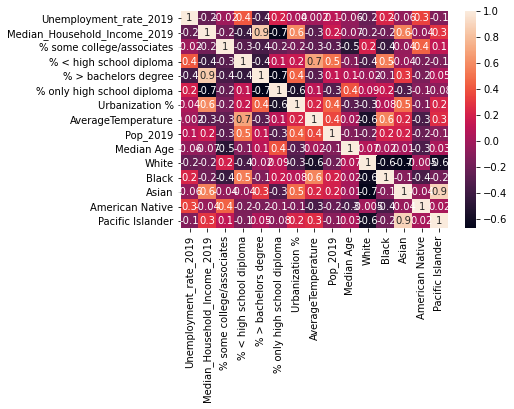

0     0.590
1     0.660
2     0.898
3     0.562
4     0.950
5     0.862
6     0.880
7     0.833
8     0.912
9     0.751
10    0.919
11    0.706
12    0.885
13    0.724
14    0.640
15    0.742
16    0.584
17    0.732
18    0.387
19    0.872
20    0.920
21    0.746
22    0.733
23    0.494
24    0.704
25    0.559
26    0.731
27    0.942
28    0.603
29    0.947
30    0.774
31    0.879
32    0.661
33    0.599
34    0.779
35    0.662
36    0.810
37    0.787
38    0.907
39    0.663
40    0.567
41    0.664
42    0.847
43    0.906
44    0.389
45    0.755
46    0.841
47    0.487
48    0.702
49    0.648
Name: Urbanization %, dtype: float64


In [420]:
#Examine correlations
stateEducationDataset = pd.read_csv("data/cleaned/educationStateDataset.csv")

colNames = ["FIPS Code",
            "State",
            'Area Name',
            "Unemployment_rate_2019",
            "Median_Household_Income_2019",
            "% some college/associates",
            "% < high school diploma",
            "% > bachelors degree",
            "% only high school diploma",
            "Urbanization %",
            "AverageTemperature",
            "Pop_2019",
            "Median Age",
            "White",
            "Black",
            "Asian",
            "American Native",
            "Pacific Islander"]

predictorDataset = stateEducationDataset[colNames]
predictorDataset.set_index("FIPS Code", inplace=True)
ax = sns.heatmap(predictorDataset.corr(), annot = True, fmt = '.1g')
plt.show()

#Merge independent and dependent variables to create a single dataframe to run out regression
predictorDataset = predictorDataset.drop(columns=["State"])
predictorDataset = predictorDataset.rename(columns={"Area Name":"State"})
predictorDataset["Median_Household_Income_2019"] = predictorDataset["Median_Household_Income_2019"]/10000
predictorDataset["Urbanization %"] = predictorDataset["Urbanization %"]/100 
df = predictorDataset.merge(dependentVarsDf,on="State",how='left')
print(df["Urbanization %"])

In [421]:
xcols = ["Median Age",
        "Black",
        "Asian",
        "White"]
X = df[xcols]
X[X < 0] = 0
print(pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns))

Median Age    278.969678
Black           7.346189
Asian           5.229798
White         191.479308
dtype: float64


In [422]:
#Regression for misinformation
ycols = ["misperception_index"]
y = df[ycols]

X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     misperception_index   R-squared:                       0.449
Model:                             OLS   Adj. R-squared:                  0.400
Method:                  Least Squares   F-statistic:                     9.151
Date:                 Sat, 20 Feb 2021   Prob (F-statistic):           1.69e-05
Time:                         16:34:48   Log-Likelihood:                -118.37
No. Observations:                   50   AIC:                             246.7
Df Residuals:                       45   BIC:                             256.3
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.9717     10.860      3.865      0.000      20.098      63.846
Median Age    -0.2157      0.179     -1.206      0.234      -0.576       0.145
Black         36.3249     10.270      3.537      0.001      15.640      57.010
Asian         49.5574     16.386      3.024      0.004      16.553      82.562
White         19.6002     11.152      1.758      0.086      -2.861      42.061
==============================================================================
Omnibus:                        1.137   Durbin-Watson:                   2.170
Prob(Omnibus):                  0.566   Jarque-Bera (JB):                1.098
Skew:                           0.216   Prob(JB):                        0.578
Kurtosis:                       2.417   Cond. No.                     2.31e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.31e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [327]:
#Regression for misinformation
ycols = ["% belief in common misperceptions"]
y = df[ycols]

X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     % belief in common misperceptions   R-squared:                       0.378
Model:                                           OLS   Adj. R-squared:                  0.322
Method:                                Least Squares   F-statistic:                     6.830
Date:                               Sat, 20 Feb 2021   Prob (F-statistic):           0.000220
Time:                                       14:47:18   Log-Likelihood:                -91.729
No. Observations:                                 50   AIC:                             193.5
Df Residuals:                                     45   BIC:                             203.0
Df Model:                                          4                                         
Covariance Type:                           nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.2345      6.374      4.743      0.000      17.396      43.073
Median Age    -0.2351      0.105     -2.239      0.030      -0.447      -0.024
Black          1.2554      6.028      0.208      0.836     -10.885      13.396
Asian        -19.3046      9.618     -2.007      0.051     -38.675       0.066
White         -8.3338      6.545     -1.273      0.209     -21.517       4.849
==============================================================================
Omnibus:                        0.205   Durbin-Watson:                   1.771
Prob(Omnibus):                  0.902   Jarque-Bera (JB):                0.081
Skew:                          -0.095   Prob(JB):                        0.961
Kurtosis:                       2.949   Cond. No.                     2.31e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.31e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [430]:
colNames = ["FIPS Code",
            "State",
            'Area Name',
            "Unemployment_rate_2019",
            "Median_Household_Income_2019",
            "% some college/associates",
            "% < high school diploma",
            "% > bachelors degree",
            "% only high school diploma",
            "Urbanization %",
            "AverageTemperature",
            "Pop_2019",
            "Median Age",
            "White",
            "Black",
            "Asian",
            "American Native",
            "Pacific Islander"]

xcols = ["Median Age",
        "Urbanization %",
        "% > bachelors degree",
        "% < high school diploma",
        "% only high school diploma"]
X = df[xcols]
X[X < 0] = 0
print(pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns))

Median Age                    421.728513
Urbanization %                 44.003164
% > bachelors degree          119.949468
% < high school diploma        23.349039
% only high school diploma    142.616335
dtype: float64


In [431]:
#Regression for misinformation
ycols = ["misperception_index"]
y = df[ycols]

X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     misperception_index   R-squared:                       0.547
Model:                             OLS   Adj. R-squared:                  0.496
Method:                  Least Squares   F-statistic:                     10.64
Date:                 Sat, 20 Feb 2021   Prob (F-statistic):           9.64e-07
Time:                         16:46:06   Log-Likelihood:                -113.44
No. Observations:                   50   AIC:                             238.9
Df Residuals:                       44   BIC:                             250.4
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         32.7393      7.996      4.094      0.000      16.624      48.855
Median Age                     0.0782      0.207      0.378      0.707      -0.338       0.495
Urbanization %                 5.8802      3.281      1.792      0.080      -0.733      12.493
% > bachelors degree           0.2861      0.135      2.127      0.039       0.015       0.557
% < high school diploma        0.7780      0.161      4.838      0.000       0.454       1.102
% only high school diploma    -0.0331      0.164     -0.202      0.841      -0.364       0.298
==============================================================================
Omnibus:                        5.013   Durbin-Watson:                   2.102
Prob(Omnibus):                  0.082   Jarque-Bera (JB):                3.910
Skew:                           0.544   Prob(JB):                        0.142
Kurtosis:                       3.832   Cond. No.                     1.32e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.32e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [428]:
colNames = ["FIPS Code",
            "State",
            'Area Name',
            "Unemployment_rate_2019",
            "Median_Household_Income_2019",
            "% some college/associates",
            "% < high school diploma",
            "% > bachelors degree",
            "% only high school diploma",
            "Urbanization %",
            "AverageTemperature",
            "Pop_2019",
            "Median Age",
            "White",
            "Black",
            "Asian",
            "American Native",
            "Pacific Islander"]

xcols = ["Median Age",
        "Urbanization %",
        "% > bachelors degree",
        "% < high school diploma",
        "% some college/associates"]
X = df[xcols]
X[X < 0] = 0
print(pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns))

Median Age                   132.860734
Urbanization %                48.621692
% > bachelors degree          78.960576
% < high school diploma       24.100987
% some college/associates     47.334541
dtype: float64


In [429]:
#Regression for misinformation
ycols = ["% belief in common misperceptions"]
y = df[ycols]

X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     % belief in common misperceptions   R-squared:                       0.502
Model:                                           OLS   Adj. R-squared:                  0.446
Method:                                Least Squares   F-statistic:                     8.881
Date:                               Sat, 20 Feb 2021   Prob (F-statistic):           6.90e-06
Time:                                       16:41:58   Log-Likelihood:                -86.147
No. Observations:                                 50   AIC:                             184.3
Df Residuals:                                     44   BIC:                             195.8
Df Model:                                          5                                         
Covariance Type:                           nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        22.5957      8.528      2.650      0.011       5.408      39.783
Median Age                   -0.2773      0.120     -2.313      0.025      -0.519      -0.036
Urbanization %               -3.9500      1.901     -2.078      0.044      -7.782      -0.118
% > bachelors degree          0.0021      0.071      0.030      0.976      -0.140       0.145
% < high school diploma       0.4226      0.119      3.542      0.001       0.182       0.663
% some college/associates     0.0021      0.095      0.022      0.983      -0.190       0.194
==============================================================================
Omnibus:                        1.919   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.383   Jarque-Bera (JB):                1.279
Skew:                          -0.382   Prob(JB):                        0.527
Kurtosis:                       3.172   Cond. No.                     2.44e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.44e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [401]:
#Regression for misinformation
ycols = ["% belief in common misperceptions"]
y = df[ycols].astype(float)

clf = LinearRegression()
clf.fit(X, y)

print(clf.score(X,y))
print(clf.coef_)

0.4528890976892711
[[-0.20569612 -0.07241116  0.33716854]]


In [388]:
colNames = ["FIPS Code",
            "State",
            'Area Name',
            "Unemployment_rate_2019",
            "Median_Household_Income_2019",
            "% some college/associates",
            "% < high school diploma",
            "% > bachelors degree",
            "% only high school diploma",
            "Urbanization %",
            "AverageTemperature",
            "Pop_2019",
            "Median Age",
            "White",
            "Black",
            "Asian",
            "American Native",
            "Pacific Islander"]

xcols = ["Median Age",
        "% some college/associates",
        "% > bachelors degree",
        "White",
        "Black",
        "Asian",
        "Urbanization %",
        "% < high school diploma",
        "AverageTemperature"]
X = df[xcols]
X[X < 0] = 0
print(pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns))

Median Age                   351.361481
% some college/associates     76.617285
% > bachelors degree         105.561607
White                        532.803904
Black                         20.082649
Asian                         16.252384
Urbanization %                61.991562
% < high school diploma       47.179297
AverageTemperature            20.536357
dtype: float64


In [389]:
#Regression for mobility
ycols = ["Mobility"]
y = df[ycols]

X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Mobility   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     17.58
Date:                Sat, 20 Feb 2021   Prob (F-statistic):           2.64e-11
Time:                        15:33:28   Log-Likelihood:                -153.15
No. Observations:                  50   AIC:                             326.3
Df Residuals:                      40   BIC:                             345.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                       110.7092     40.599      2.727      0.009      28.656     192.762
Median Age                   -1.3482      0.515     -2.618      0.012      -2.389      -0.308
% some college/associates    -0.5729      0.404     -1.416      0.164      -1.390       0.245
% > bachelors degree         -0.9268      0.293     -3.163      0.003      -1.519      -0.335
White                        31.3454     26.912      1.165      0.251     -23.046      85.737
Black                        21.3547     27.506      0.776      0.442     -34.236      76.946
Asian                       -26.9274     43.858     -0.614      0.543    -115.567      61.712
Urbanization %              -21.0406      8.597     -2.447      0.019     -38.416      -3.665
% < high school diploma      -2.3268      0.559     -4.159      0.000      -3.458      -1.196
AverageTemperature           -0.3503      0.309     -1.134      0.263      -0.974       0.274
==============================================================================
Omnibus:                        1.050   Durbin-Watson:                   2.203
Prob(Omnibus):                  0.592   Jarque-Bera (JB):                0.488
Skew:                          -0.215   Prob(JB):                        0.784
Kurtosis:                       3.221   Cond. No.                     4.41e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.41e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [433]:
colNames = ["FIPS Code",
            "State",
            'Area Name',
            "Unemployment_rate_2019",
            "Median_Household_Income_2019",
            "% some college/associates",
            "% < high school diploma",
            "% > bachelors degree",
            "% only high school diploma",
            "Urbanization %",
            "AverageTemperature",
            "Pop_2019",
            "Median Age",
            "White",
            "Black",
            "Asian",
            "American Native",
            "Pacific Islander"]

xcols = ["White",
        "Black",
        "Asian",
        "Median Age",
        "% some college/associates",
        "Urbanization %",
        "% < high school diploma",
        "% > bachelors degree",
        "AverageTemperature"]
X = df[xcols]
X[X < 0] = 0
print(pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns))

White                        532.803904
Black                         20.082649
Asian                         16.252384
Median Age                   351.361481
% some college/associates     76.617285
Urbanization %                61.991562
% < high school diploma       47.179297
% > bachelors degree         105.561607
AverageTemperature            20.536357
dtype: float64


In [434]:
#Regression for covid
ycols = ["positivity_rate"]
y = df[ycols]*1000

X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        positivity_rate   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     3.372
Date:                Sat, 20 Feb 2021   Prob (F-statistic):            0.00368
Time:                        16:53:47   Log-Likelihood:                -259.66
No. Observations:                  50   AIC:                             539.3
Df Residuals:                      40   BIC:                             558.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                       407.3965    341.677      1.192      0.240    -283.158    1097.951
White                       271.1170    226.491      1.197      0.238    -186.639     728.873
Black                       208.1897    231.486      0.899      0.374    -259.661     676.040
Asian                       127.4613    369.104      0.345      0.732    -618.526     873.449
Median Age                  -11.9971      4.333     -2.769      0.008     -20.755      -3.240
% some college/associates     1.0828      3.404      0.318      0.752      -5.796       7.962
Urbanization %              -66.3366     72.354     -0.917      0.365    -212.570      79.897
% < high school diploma      -5.6801      4.709     -1.206      0.235     -15.197       3.836
% > bachelors degree         -2.7528      2.466     -1.116      0.271      -7.737       2.232
AverageTemperature            5.4991      2.599      2.116      0.041       0.247      10.751
==============================================================================
Omnibus:                       23.974   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.985
Skew:                           1.566   Prob(JB):                     5.64e-09
Kurtosis:                       5.903   Cond. No.                     4.41e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.41e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [399]:
#Regression for covid
ycols = ["Output"]
y = df[ycols]*1000

X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Output   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     3.399
Date:                Sat, 20 Feb 2021   Prob (F-statistic):            0.00348
Time:                        15:37:32   Log-Likelihood:                -257.14
No. Observations:                  50   AIC:                             534.3
Df Residuals:                      40   BIC:                             553.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                       486.7597    324.867      1.498      0.142    -169.822    1143.341
White                       -89.6641    215.349     -0.416      0.679    -524.900     345.572
Black                        32.3336    220.098      0.147      0.884    -412.501     477.168
Asian                      -420.5777    350.946     -1.198      0.238   -1129.865     288.710
Median Age                   -1.4045      4.120     -0.341      0.735      -9.731       6.922
% some college/associates    -6.8094      3.236     -2.104      0.042     -13.350      -0.269
Urbanization %              183.1338     68.795      2.662      0.011      44.094     322.173
% < high school diploma       0.3564      4.477      0.080      0.937      -8.692       9.405
% > bachelors degree         -3.9276      2.345     -1.675      0.102      -8.667       0.812
AverageTemperature           -1.6697      2.471     -0.676      0.503      -6.664       3.324
==============================================================================
Omnibus:                        2.610   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.271   Jarque-Bera (JB):                2.469
Skew:                           0.520   Prob(JB):                        0.291
Kurtosis:                       2.677   Cond. No.                     4.41e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.41e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""